In [13]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre

from scipy import interp



#import data
data = np.loadtxt("arrhythmia.csv", delimiter = ",")

#transpose data, to transverse columns easily 
data = np.transpose(data)

#go to each column, and replace every 1000 with the average value of the non-1000 values in that column
for i in range(len(data)):
    column = data[i]
    numberOfNon1000 = len(column)
    sum = 0
    for j in range(len(column)):
        if (data[i][j] != 1000):
            sum += data[i][j]
        else:
            numberOfNon1000 -=1
    for j in range(len(column)):
        if (data[i][j] == 1000):
            data[i][j] = sum / numberOfNon1000

#sanity check - are there any 1000s in the data still?
for column in data:
    for i in column:
        if (i == 1000):
            print ("bad")
            
            
#re-transpose data
data = np.transpose(data)

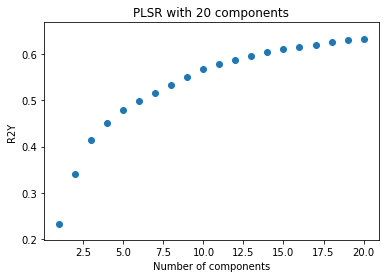

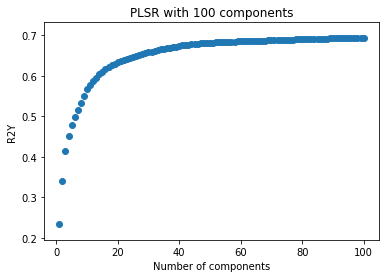

In [27]:
# Implement PLSR
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

X = data[:, 0:277]
Y = data[:, 278]
Xnorm = pre.scale(X)
Ynorm = pre.scale(Y)


# Try with 20 components, determine R2 scores, and plot percent variance
r_arr = []
for i in range(1,21):
    pls_i = PLSRegression(n_components = i)
    pls_i.fit(Xnorm, Ynorm)
    Y_predi = pls_i.predict(Xnorm)
    r_arr.append(r2_score(Ynorm , Y_predi))
    
index = np.arange(1,21)
plt.scatter(index,r_arr);
plt.xlabel('Number of components');
plt.ylabel('R2Y');
plt.title('PLSR with 20 components');

# Try with 100 components, determine R2 scores, and plot percent variance
r_arr2 = []
for i in range(1,101):
    pls_i = PLSRegression(n_components = i)
    pls_i.fit(Xnorm, Ynorm)
    Y_predi = pls_i.predict(Xnorm)
    r_arr2.append(r2_score(Ynorm , Y_predi))

index2 = np.arange(1,101)
plt.figure();
plt.scatter(index2, r_arr2); 
plt.xlabel('Number of components');
plt.ylabel('R2Y');
plt.title('PLSR with 100 components');

In [26]:
# Perform leave-one-out cross validation with 100 components
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

Y_obs = []
Y_pred = []
pls_loo = PLSRegression(n_components = 100)

for train_index, test_index in loo.split(X, Y):    
    pls_loo.fit_transform(X[train_index], Y[train_index])
    pls_loo.transform(X[test_index])
    
    ypred = pls_loo.predict(X[test_index])    
    yobs = Y[test_index]
    
    Y_obs.append(ypred[0,0])
    Y_pred.append(yobs[0]) 
    
r2_loo = r2_score(Y_obs, Y_pred)
print('R2 value: ', r2_loo)  

R2 value:  -0.01712539449533046


In [75]:
#attempting PLS-DA, only trying to distinguish between arrhythmia and no arr


#normalize X data according to how Yi says it should be
X_normal = pre.scale(X)

#make Y matrix of 0s and 1s - 0 = no arr, 1 = some type of arr
Y_binary = []
for i in range(len(Y)):
    if (Y[i] == 1): Y_binary.append(0)
    else: Y_binary.append(1)

#do PLSR
plsda = PLSRegression(n_components = 4)
pc_space = plsda.fit_transform(X_normal, Y_binary)[0]
Y_plsda = plsda.predict(X_normal)

#change predictions from PLS into binary values, and compare to Y_binary
for i in range(len(Y_plsda)):
    if (Y_plsda[i] > 0.5):
        Y_plsda[i] = 1
    else:
        Y_plsda[i] = 0

correct = 0
for i in range(len(Y_binary)):
    if (Y_binary[i] == Y_plsda[i]):
        correct += 1
print ("Percent correctly identified: (no crossvalidation): ", correct / len(Y_binary))


Percent correctly identified: (no crossvalidation):  0.8561946902654868


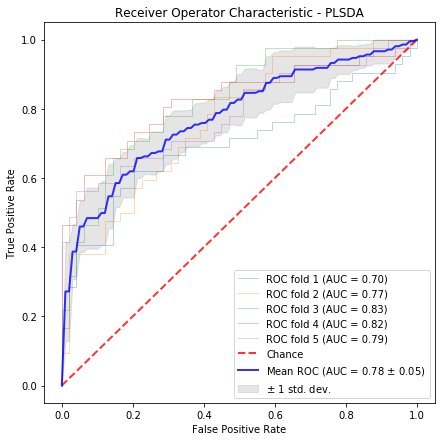

In [77]:
# trying to make an ROC curve with the crossvalidation results
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Y_binary = np.array(Y_binary)

plt.figure(figsize = (7,7))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

cv = StratifiedKFold(n_splits = 5)
i = 1
for train,test in cv.split(X_normal, Y_binary):
    plsda.fit(X_normal[train], Y_binary[train])
    Y_plsda = plsda.predict(X[test])
    fpr, tpr, thresholds = roc_curve(Y_binary[test], Y_plsda)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.legend()
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic - PLSDA')

plt.legend();